<h1>Microdata Protection - Homework1 Privacy Preserving Information Access </h1>
<h3>Author: Piron Samuel - 2121724</h3>

In [1]:
#Load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from scipy.linalg import cholesky
from sklearn.decomposition import PCA

In [2]:
#Load the dataset
heartdf = pd.read_csv("heart.csv")

heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


<h5>The first diagram shows the <em>thalachh</em> column of the dataset, divided in 30 bins</h5>

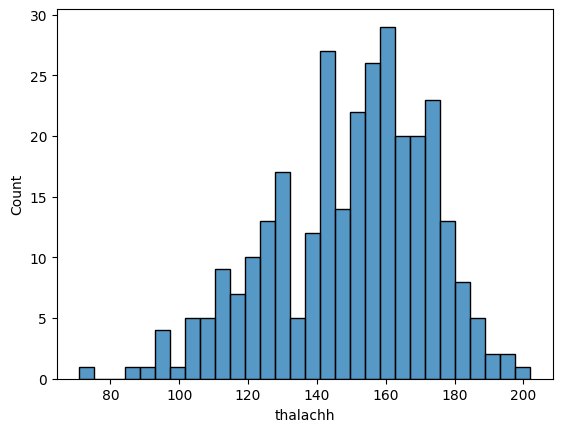

In [3]:
sns.histplot(data=heartdf, x='thalachh', bins=30)
plt.show()

<h5>The second diagram shows the <em>chol</em> column of the dataset, divided in 30 bins</h5>

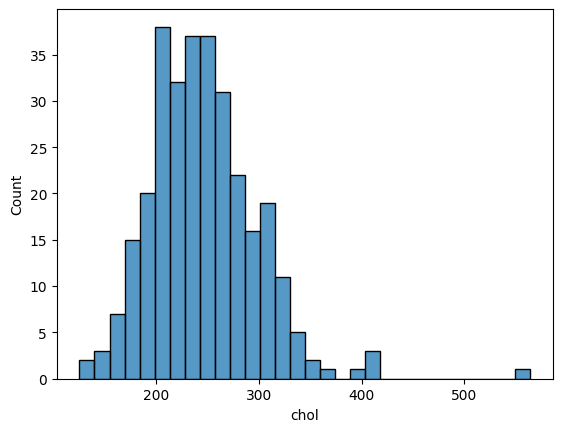

In [4]:
sns.histplot(data=heartdf, x='chol', bins=30)
plt.show()

<h5>The third diagram shows the <em>cp</em> column of the dataset, divided in 30 bins</h5>

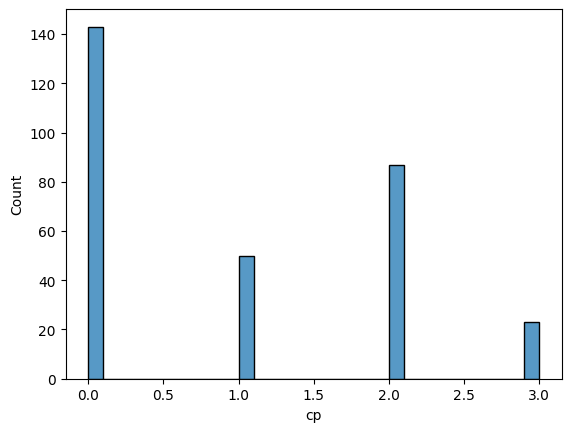

In [5]:
sns.histplot(data=heartdf, x='cp', bins=30)
plt.show()

<h2>MACRODATA</h2>

<h5>Macrodata are data that are realised in aggregated form. they are realised under the form of tables; in this case we have the <strong>Count</strong> variable.</h5>
<h5>In this table it is shown the comparison between <strong>sex</strong> and the <strong>cp (chest pain)</strong></h5>

In [6]:
heart_attack_pivot = heartdf[['sex','cp']]

heart_attack_pivot = pd.DataFrame(heart_attack_pivot.groupby('sex').value_counts())\
    .reset_index().rename({0: 'count'}, axis=1)\
    .pivot_table(index='sex', columns='cp', values='count')\
    .fillna(0)

heart_attack_pivot

cp,0,1,2,3
sex,,,,
0,39.0,18.0,35.0,4.0
1,104.0,32.0,52.0,19.0


<h5>In this table it is shown the comparison between <strong>sex</strong> and the <strong>restecg (resting electrocardiographic results)</strong></h5>

In [7]:
heart_attack_pivot2 = heartdf[['sex','restecg']]

heart_attack_pivot2 = pd.DataFrame(heart_attack_pivot2.groupby('sex').value_counts())\
    .reset_index().rename({0: 'count'}, axis=1)\
    .pivot_table(index='sex', columns='restecg', values='count')\
    .fillna(0)

heart_attack_pivot2

restecg,0,1,2
sex,,,
0,44.0,49.0,3.0
1,103.0,103.0,1.0


<h5> Cell suppression is the most common, and oldest, applied technique for protecting frequency data in tabular form. It is used for low frequency count data, sensitive cells, (i.e., those with small, unweighted counts) are identified in the table.</h5>
<h6>In this case the threeshow was set to<b>20</b></h6>


In [8]:
privatized_hap = heart_attack_pivot.copy()
privatized_hap[heart_attack_pivot <20] = "SUPPRESSED"
privatized_hap

<ipython-input-8-8387f238fa8f>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'SUPPRESSED' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  privatized_hap[heart_attack_pivot <20] = "SUPPRESSED"


cp,0,1,2,3
sex,,,,
0,39.0,SUPPRESSED,35.0,SUPPRESSED
1,104.0,32.0,52.0,SUPPRESSED


<h5>Another tecniques that can be used to protect sensitive cell is the Rounding. Rounding a value to the closest multiple. </h5>
<h5>Checking the table befor and after applying it is evident that every value inside the table was rounded.</h5>

In [9]:
privatized_hap = heart_attack_pivot.copy()

def custom_round_last_digit(num):
    last_digit = num % 10
    if last_digit in [0, 1, 2, 3, 4]:
        return num - last_digit
    else:
        return (num - last_digit) + 10

privatized_hap = privatized_hap.applymap(custom_round_last_digit)

privatized_hap

<ipython-input-9-091962ed68fb>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  privatized_hap = privatized_hap.applymap(custom_round_last_digit)


cp,0,1,2,3
sex,,,,
0,40.0,20.0,40.0,0.0
1,100.0,30.0,50.0,20.0


<h5>An important tecnique to protect sensitive cells is the Roll Up Categories. In this case categories are gouped together and increase the numer of subjects in the macro-category.</h5>
<h5>In the table columns 2 and the 3 column were put togheter.</h5>

In [10]:
heart_attack_pivot['2-3'] = heart_attack_pivot[2] + heart_attack_pivot[3]

heart_attack_pivot = heart_attack_pivot.drop([2, 3], axis=1)

heart_attack_pivot

cp,0,1,2-3
sex,,,
0,39.0,18.0,39.0
1,104.0,32.0,71.0


<h2>(n-k) Rule</h2>

<h5>To determine which cells are sensitive using the n-k rule, we need to determine how much each individual is responsible for the value of the cell.</h5>

In [11]:
def nkrule(values, n, k):
    contribution = values/np.sum(values)
    print(f"contributions: {contribution}")
    print(f"number of individuals contributing more than {k}: {np.sum(contribution>k)}")
    return np.sum(contribution>k)<n

In [12]:
heartdf['trtbps_bin'] = pd.cut(heartdf['trtbps'], bins=[100, 125, 150, 175, 200], labels=['100-125', '126-150', '151-175', '176-200'])

macrodata_cpt_binned_cp_mean = heartdf.pivot_table(index='sex', columns='trtbps_bin', values='cp', aggfunc='mean').fillna(0)

print(macrodata_cpt_binned_cp_mean)

trtbps_bin   100-125   126-150   151-175  176-200
sex                                              
0           1.266667  0.980769  1.125000      0.0
1           0.807229  0.938776  1.263158      2.0


<ipython-input-12-07e9e0ec3e41>:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  macrodata_cpt_binned_cp_mean = heartdf.pivot_table(index='sex', columns='trtbps_bin', values='cp', aggfunc='mean').fillna(0)


In [13]:
n = 2
k = 0.30


contr = np.array(heartdf[(heartdf['sex']==1) &
                         (heartdf['trtbps_bin']=='176-200')]['cp'])
print(contr)
print(f"is the cell sensible according to {n}-{k} rule?: {nkrule(contr, n, k)}\n")
k = 0.4
print(f"is the cell sensible according to {n}-{k} rule?: {nkrule(contr, n, k)}\n")

[3 2 1]
contributions: [0.5        0.33333333 0.16666667]
number of individuals contributing more than 0.3: 2
is the cell sensible according to 2-0.3 rule?: False

contributions: [0.5        0.33333333 0.16666667]
number of individuals contributing more than 0.4: 1
is the cell sensible according to 2-0.4 rule?: True



In [14]:
def check_p_percentage_rule(contributions, p):

    total_contribution = np.sum(contributions)
    contribution_percentages = contributions / total_contribution
    sorted_contributions = sorted(contribution_percentages, reverse=True)

    if len(sorted_contributions) < 2:
        return False, None, None

    v1 = sorted_contributions[0]
    v2 = sorted_contributions[1]
    value = np.mean(contributions)

    #print(value)
    #print(v1)
    #print(v2)
    condition = value - v1 - v2 < (p / 100) * v1

    return condition, v1, v2

contr = np.array(heartdf[(heartdf['sex'] == 1) & (heartdf['trtbps_bin'] == '176-200')]['cp'])
print(f"Contributions: {contr}")

p = 40
is_sensitive, v1, v2 = check_p_percentage_rule(contr, p)

if is_sensitive:
    print(f"The cell is sensitive. v1: {v1}, v2: {v2}")
else:
    print(f"The cell is NOT sensitive. v1: {v1}, v2: {v2}")


Contributions: [3 2 1]
The cell is NOT sensitive. v1: 0.5, v2: 0.3333333333333333


In [15]:
macrodata_cpt = heartdf[['sex', 'trtbps', 'cp']]\
                       .groupby(["sex", "cp"]).mean().reset_index()\
                       .pivot_table(index='sex', columns='cp', values='trtbps')\
                       .fillna(0)
macrodata_cpt

cp,0,1,2,3
sex,,,,
0,138.589744,128.055556,127.885714,147.500000
1,129.557692,128.593750,132.057692,139.473684


In [16]:
n = 5
k = 0.03


contr = np.array(heartdf[(heartdf['sex']==0) &
                         (heartdf['cp']==2)]['trtbps'])
#print(contr)
print(f"is the cell sensible according to {n}-{k} rule?: {nkrule(contr, n, k)}\n")
k = 0.05
print(f"is the cell sensible according to {n}-{k} rule?: {nkrule(contr, n, k)}\n")

contributions: [0.02904379 0.02680965 0.02680965 0.03127793 0.03172475 0.03016086
 0.03462913 0.0357462  0.03127793 0.02859696 0.02904379 0.02412869
 0.03016086 0.02457551 0.02725648 0.0227882  0.02569258 0.02457551
 0.02680965 0.03127793 0.02680965 0.02502234 0.02412869 0.02100089
 0.03395889 0.03038427 0.0357462  0.02680965 0.02680965 0.02680965
 0.03127793 0.02636282 0.03261841 0.0308311  0.02904379]
number of individuals contributing more than 0.03: 14
is the cell sensible according to 5-0.03 rule?: False

contributions: [0.02904379 0.02680965 0.02680965 0.03127793 0.03172475 0.03016086
 0.03462913 0.0357462  0.03127793 0.02859696 0.02904379 0.02412869
 0.03016086 0.02457551 0.02725648 0.0227882  0.02569258 0.02457551
 0.02680965 0.03127793 0.02680965 0.02502234 0.02412869 0.02100089
 0.03395889 0.03038427 0.0357462  0.02680965 0.02680965 0.02680965
 0.03127793 0.02636282 0.03261841 0.0308311  0.02904379]
number of individuals contributing more than 0.05: 0
is the cell sensible acc

In [17]:
def check_p_percentage_rule(contributions, p):

    total_contribution = np.sum(contributions)
    contribution_percentages = contributions / total_contribution
    sorted_contributions = sorted(contribution_percentages, reverse=True)

    if len(sorted_contributions) < 2:
        return False, None, None

    v1 = sorted_contributions[0]
    v2 = sorted_contributions[1]
    value = np.mean(contributions)

    print(value)
    print(v1)
    print(v2)
    condition = value - v1 - v2 < (p / 100) * v1

    return condition, v1, v2

contr = np.array(heartdf[(heartdf['sex']==0) &
                         (heartdf['cp']==2)]['trtbps'])
print(f"Contributions: {contr}")

p = 30
is_sensitive, v1, v2 = check_p_percentage_rule(contr, p)

if is_sensitive:
    print(f"The cell is sensitive. v1: {v1}, v2: {v2}")
else:
    print(f"The cell is NOT sensitive. v1: {v1}, v2: {v2}")


Contributions: [130 120 120 140 142 135 155 160 140 128 130 108 135 110 122 102 115 110
 120 140 120 112 108  94 152 136 160 120 120 120 140 118 146 138 130]
127.88571428571429
0.035746201966041107
0.035746201966041107
The cell is NOT sensitive. v1: 0.035746201966041107, v2: 0.035746201966041107


In [18]:
def check_p_percentage_rule(contributions, p, q):

    total_contribution = np.sum(contributions)
    contribution_percentages = contributions / total_contribution
    sorted_contributions = sorted(contribution_percentages, reverse=True)

    if len(sorted_contributions) < 2:
        return False, None, None

    v1 = sorted_contributions[0]
    v2 = sorted_contributions[1]
    value = np.mean(contributions)
    value1  = p/q

    print(value)
    print(value1)
    print(v1)
    print(v2)
    condition = value - v1 - v2 < (value1 / 100) * v1

    return condition, v1, v2

contr = np.array(heartdf[(heartdf['sex']==0) &
                         (heartdf['cp']==2)]['trtbps'])
print(f"Contributions: {contr}")

p = 40
q = 80
is_sensitive, v1, v2 = check_p_percentage_rule(contr, p, q)

if is_sensitive:
    print(f"The cell is sensitive. v1: {v1}, v2: {v2}")
else:
    print(f"The cell is NOT sensitive. v1: {v1}, v2: {v2}")


Contributions: [130 120 120 140 142 135 155 160 140 128 130 108 135 110 122 102 115 110
 120 140 120 112 108  94 152 136 160 120 120 120 140 118 146 138 130]
127.88571428571429
0.5
0.035746201966041107
0.035746201966041107
The cell is NOT sensitive. v1: 0.035746201966041107, v2: 0.035746201966041107


<h1>MICRODATA - MASKING</h1>

<h2>Sampling</h2>
<h5>Sampling is used to remove from the dataset some observation to decrease the risk of identification by a malicious person.</h5>

In [19]:
#select a sample of the individuals, by randomly sampling the indexes
sampled_individuals = npr.choice(heartdf.index.to_list(), int(len(heartdf.index.to_list())*0.3), replace=False)

#filter out individuals whose index is not among the sampled ones
sampled_adultdf = heartdf.loc[sampled_individuals, :]
sampled_adultdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,trtbps_bin
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2,1,100-125
278,58,0,1,136,319,1,0,152,0,0.0,2,2,2,0,126-150
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1,126-150
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0,100-125
188,50,1,2,140,233,0,1,163,0,0.6,1,1,3,0,126-150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,71,0,0,112,149,0,1,125,0,1.6,1,0,2,1,100-125
256,58,1,0,128,259,0,0,130,1,3.0,1,2,3,0,126-150
87,46,1,1,101,197,1,1,156,0,0.0,2,0,3,1,100-125
127,67,0,2,152,277,0,1,172,0,0.0,2,1,2,1,151-175


<h2> Local Suppression </h2>
<h5>In local Suppression I replace attributes or cells that contribute to disclosure risk with <strong>Missing Value</strong>.

In [20]:
heartdf[(heartdf['sex']==0) &(heartdf['cp']==2)]['trtbps']

,trtbps
11,130
15,120
16,120
28,140
35,142
36,135
38,155
39,160
40,140
48,128


In [21]:
heartdf.loc[(heartdf['sex']==0)
             & (heartdf['cp']==2)
             & (heartdf['trtbps']==120), 'trtbps']

,trtbps
15,120
16,120
105,120
115,120
136,120
140,120
142,120


<h5>Now the cells that have value = 120 were removed.</h5>

In [22]:
heartdf.loc[(heartdf['sex']==0)
             & (heartdf['cp']==2)
             & (heartdf['trtbps']==120), 'trtbps'] = "SUPPRESSED"

<ipython-input-22-b9eb58973384>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'SUPPRESSED' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heartdf.loc[(heartdf['sex']==0)


In [23]:
heartdf.loc[(heartdf['sex']==0)
             & (heartdf['cp']==2), 'trtbps']

,trtbps
11,130
15,SUPPRESSED
16,SUPPRESSED
28,140
35,142
36,135
38,155
39,160
40,140
48,128


In [24]:
# reset the adult dataframe
heartdf = pd.read_csv("heart.csv")

<h2>Global Recoding</h2>
<h5>Global Recoding is a tecnique where a range of values (or categories) are grouped togheter or recoded into broader categories. This is useful to semplify data and mantain privacy.

In [25]:
heartdf['trt'] = pd.cut(heartdf['trtbps'], bins=5)
heartdf[['trtbps', 'trt']]

,trtbps,trt
0,145,"(136.4, 157.6]"
1,130,"(115.2, 136.4]"
2,130,"(115.2, 136.4]"
3,120,"(115.2, 136.4]"
4,120,"(115.2, 136.4]"
...,...,...
298,140,"(136.4, 157.6]"
299,110,"(93.894, 115.2]"
300,144,"(136.4, 157.6]"
301,130,"(115.2, 136.4]"


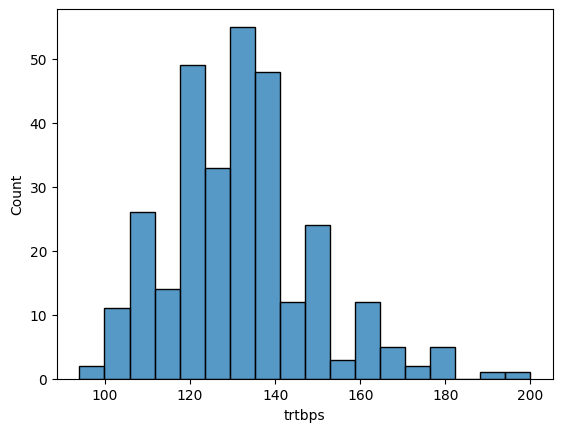

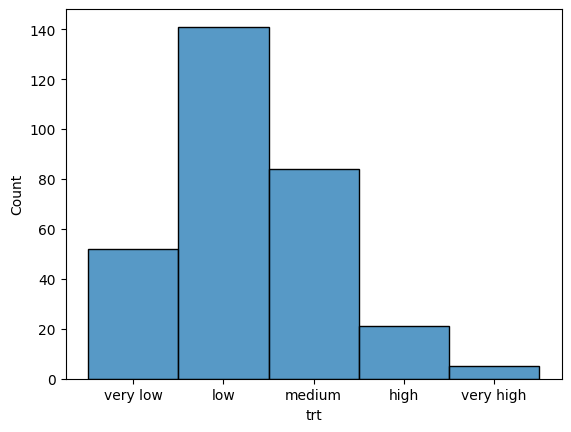

In [26]:
sns.histplot(data=heartdf, x = heartdf['trtbps'])
plt.show()
labels = ['very low', 'low', 'medium', 'high', 'very high']
heartdf['trt'] = pd.cut(heartdf['trtbps'], bins=5, labels=labels)
sns.histplot(data=heartdf, x='trt')
plt.show()

<h5>The first diagram shows the distribution of the <strong>trtbps</strong> values before recoding. We can see that the numerical values are divided into intervals (e.g. the most common resting blood pressure values are between 120 and 140 with a peak around 130-140). In the second diagram we can see the distribution of the recoded <strong>trt</strong> values (e.g. blood pressure ranges after global recoding).</h5>

In [27]:
heartdf['trt']

,trt
0,medium
1,low
2,low
3,low
4,low
...,...
298,medium
299,very low
300,medium
301,low


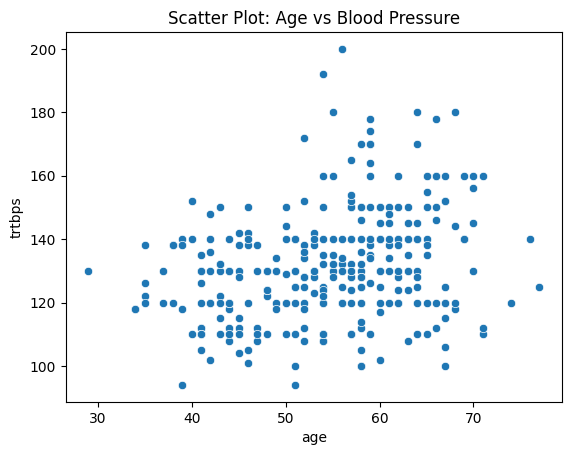

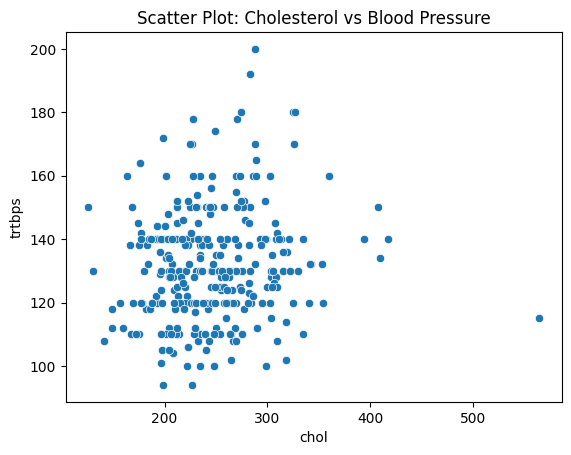

In [28]:
sns.scatterplot(data=heartdf, x='age', y='trtbps')
plt.title('Scatter Plot: Age vs Blood Pressure')
plt.show()

sns.scatterplot(data=heartdf, x='chol', y='trtbps')
plt.title('Scatter Plot: Cholesterol vs Blood Pressure')
plt.show()

<h5>The first image shows a scatter plot that represents the relationship between two variables: <strong>Age</strong> and <strong>trtbps</strong>. The majority of data points fall between trt range 120 and 160; from the image above we can see outliers (e.g. the one in the top corresponding age~50).</h5>
<h5>The second image shows the relationship between <strong>chol</strong> and <strong>trtbps</strong>. Like in the first case, we can see some outliers where chol exceed or even the blood pressure. One important outlier has the chol level near 500 mg/dl. </h5>

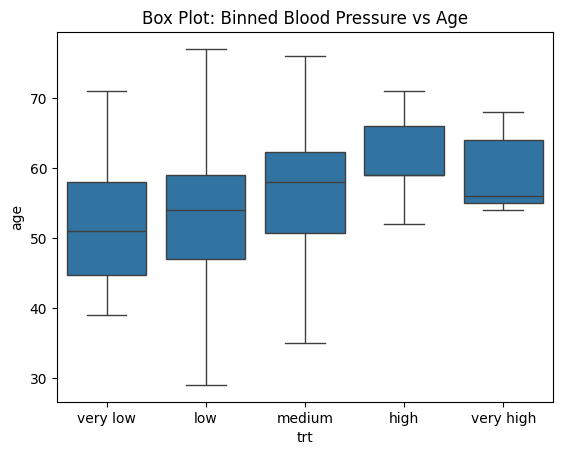

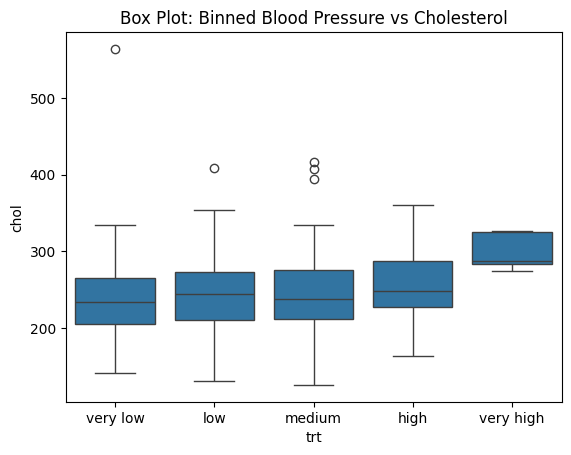

In [29]:
sns.boxplot(data=heartdf, x='trt', y='age')
plt.title('Box Plot: Binned Blood Pressure vs Age')
plt.show()

sns.boxplot(data=heartdf, x='trt', y='chol')
plt.title('Box Plot: Binned Blood Pressure vs Cholesterol')
plt.show()

<Axes: xlabel='trt', ylabel='Count'>

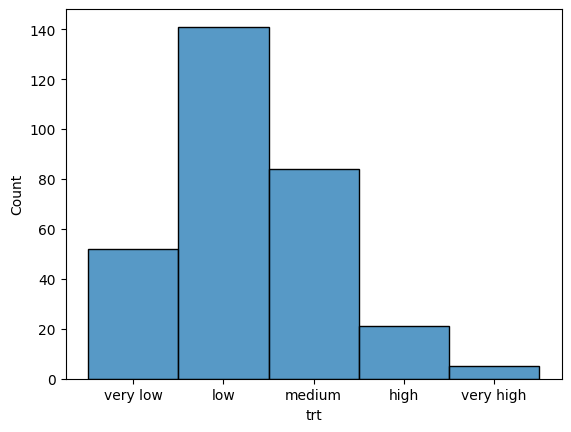

In [30]:
sns.histplot(data=heartdf, x='trt')

In [31]:
heartdf['trt'] = pd.qcut(heartdf['trtbps'], 10, duplicates='drop')

# Sostituisci la colonna 'trtbps' con i valori di 'trt'
heartdf['trtbps'] = heartdf['trt']

# Rimuovi la colonna 'trt' se non serve più
heartdf = heartdf.drop(columns=['trt'])
heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,"(144.0, 152.0]",233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,"(126.0, 130.0]",250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,"(126.0, 130.0]",204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,"(110.0, 120.0]",236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,"(110.0, 120.0]",354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,"(134.0, 140.0]",241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,"(93.999, 110.0]",264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,"(140.0, 144.0]",193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,"(126.0, 130.0]",131,0,1,115,1,1.2,1,1,3,0


<h2>Top & Bottom Coding</h2>
<h5>Top & Bottom Coding is often used to handle the outliers in the data. It is also used in sensitive datasets to prevent people that have extreme values to get identified. In this dataset, with <strong>>180</strong> I avoid the risk of identification by a malicious person.</h5>

In [32]:
#top coding
#greater_than_180 = heartdf[heartdf['trtbps']>180].index.to_list()

In [33]:
#bottom coding
#smaller_than_120 = heartdf[heartdf['trtbps']<120].index.to_list()

In [34]:
#heartdf.loc[greater_than_180, 'trtbps'] = ">180"
#heartdf.loc[smaller_than_120, 'trtbps'] = "<120"
#heartdf.loc[(heartdf['trtbps']==">180") | (heartdf['trtbps']=="<120"), ['cp', 'chol', 'thalachh', 'trtbps']]

In [35]:
heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,"(144.0, 152.0]",233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,"(126.0, 130.0]",250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,"(126.0, 130.0]",204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,"(110.0, 120.0]",236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,"(110.0, 120.0]",354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,"(134.0, 140.0]",241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,"(93.999, 110.0]",264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,"(140.0, 144.0]",193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,"(126.0, 130.0]",131,0,1,115,1,1.2,1,1,3,0


In [36]:
# reset the adult dataframe
#heartdf = pd.read_csv("heart.csv")

<h2>Resampling</h2>
<h5>Resampling is an important tecnique that is used to smooth out alterations and to stabilize estimate in the dat by using random sampling and sorting. This tecnoque generates several versions of the data, sorts them and computes means to reduce noise and variability.</h5>
<h5>Here I applied the resampling process to the <strong>chol</strong> column.
The original cholesterol values have been replaced with the smoothed one.</h5>

In [37]:
def resampling_values(data, k=10):

    sM = npr.choice(data, size=(len(data), k))
    rows, cols = sM.shape
    sMs = np.array([sorted(sM[:, c]) for c in range(cols)]).T
    means = np.mean(sMs, axis=1)
    released = np.zeros(len(data))
    for e, i in enumerate(np.argsort(data)):
        released[i] = means[e]
    return released

In [38]:
values = resampling_values(heartdf['chol'])
print(f"original: {heartdf['chol'].to_list()[:10]}")
print(f"released: {list(values[:10])}")
heartdf['chol'] = values


original: [233, 250, 204, 236, 354, 192, 294, 263, 199, 168]
released: [231.7, 251.0, 203.3, 237.0, 360.5, 191.9, 291.8, 261.9, 200.0, 170.0]


In [39]:
# reset the adult dataframe
heartdf = pd.read_csv("heart.csv")

-------------------- <h1>MATLAB CODE</h1>-----------------------

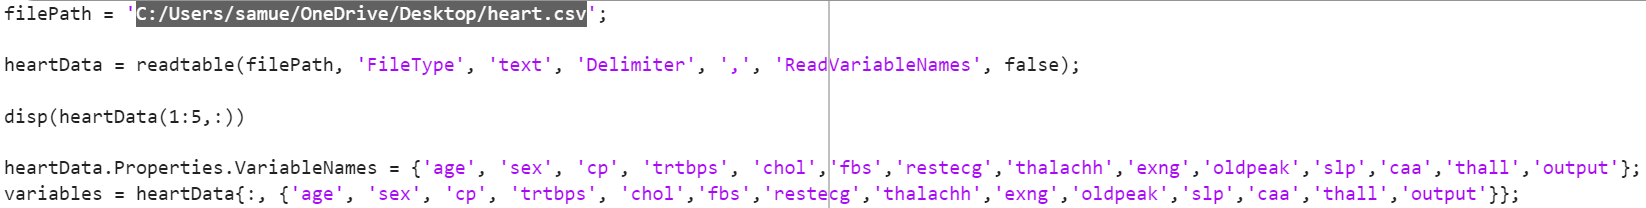

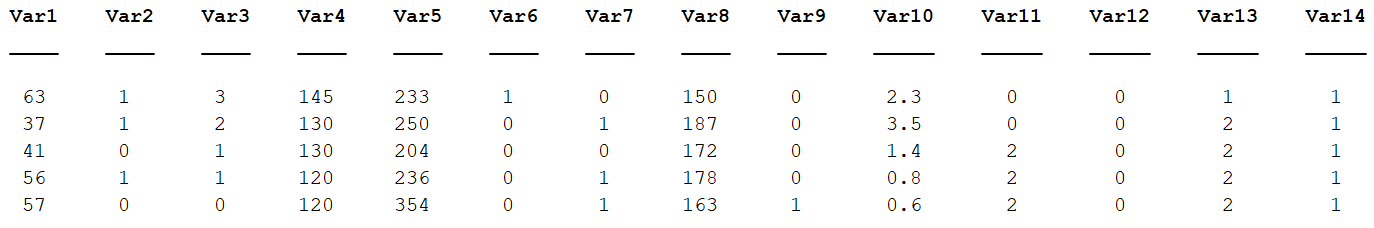

<h5>Now let's plot the correlation matrix </h5>

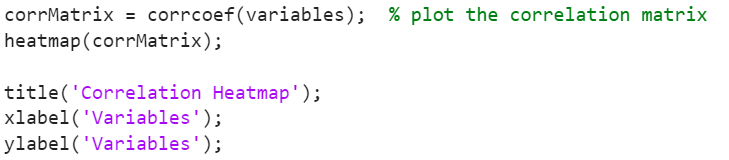

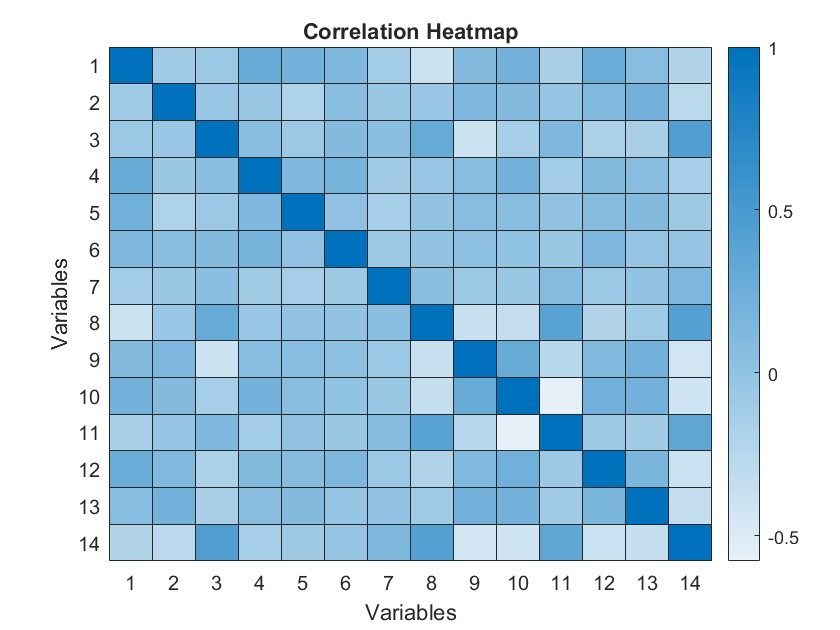

<h5>With this correlation matrix we can see the correlation between the data.</h5>

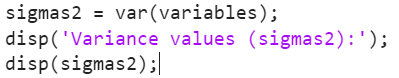

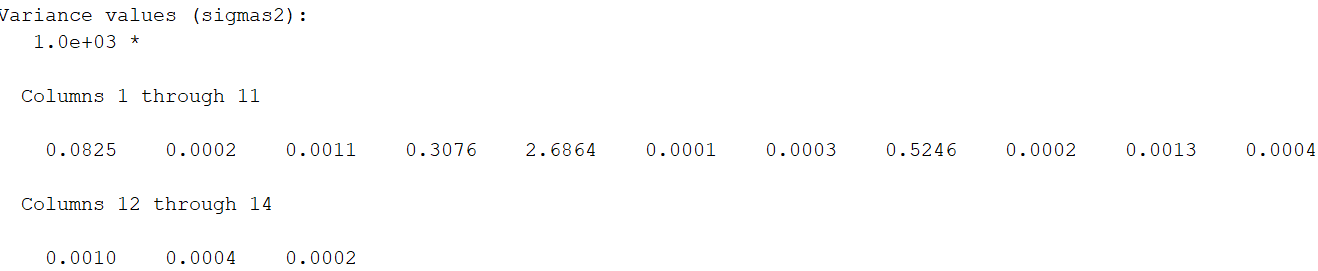

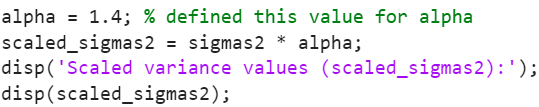

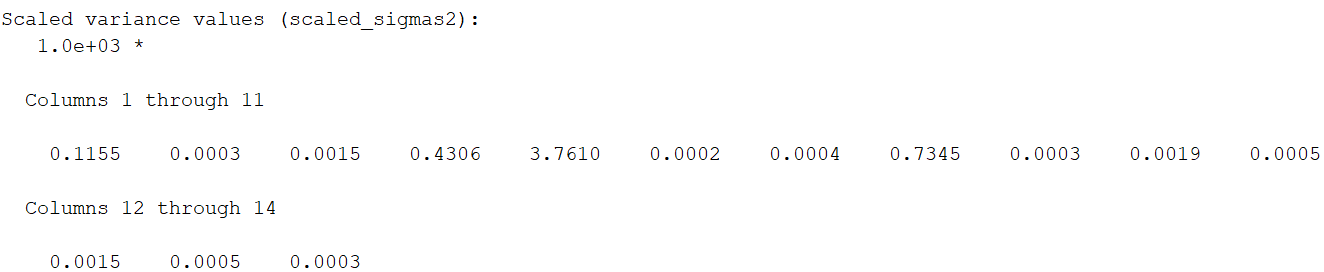

<h2>Random noise: uncorrelated additive noise</h2>

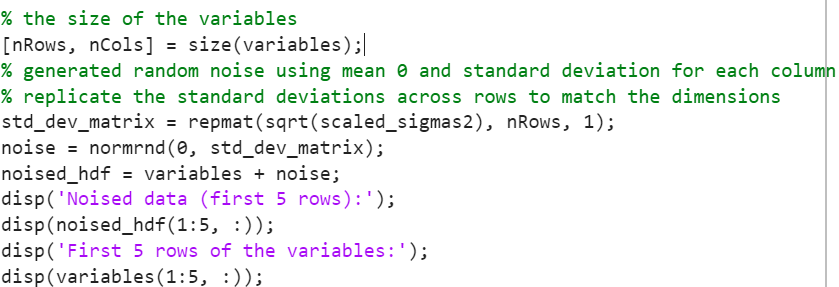

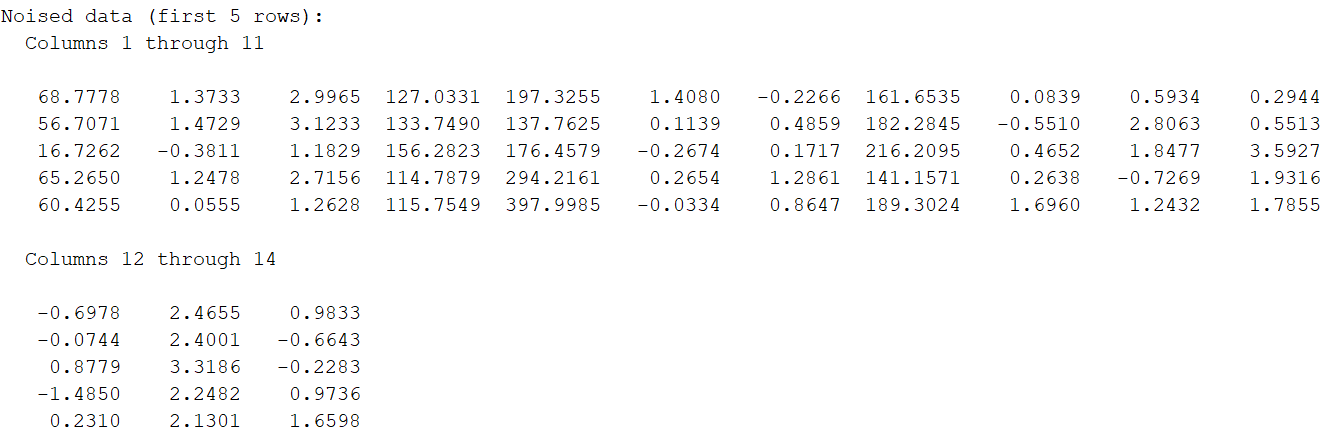

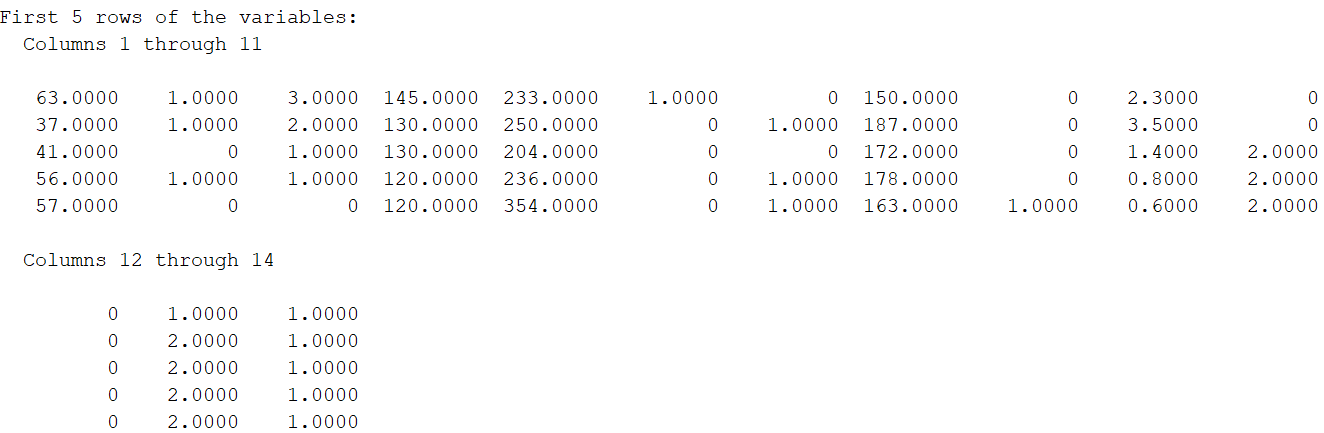

<h5>In the tables above we can see that the noise is applied</h5>

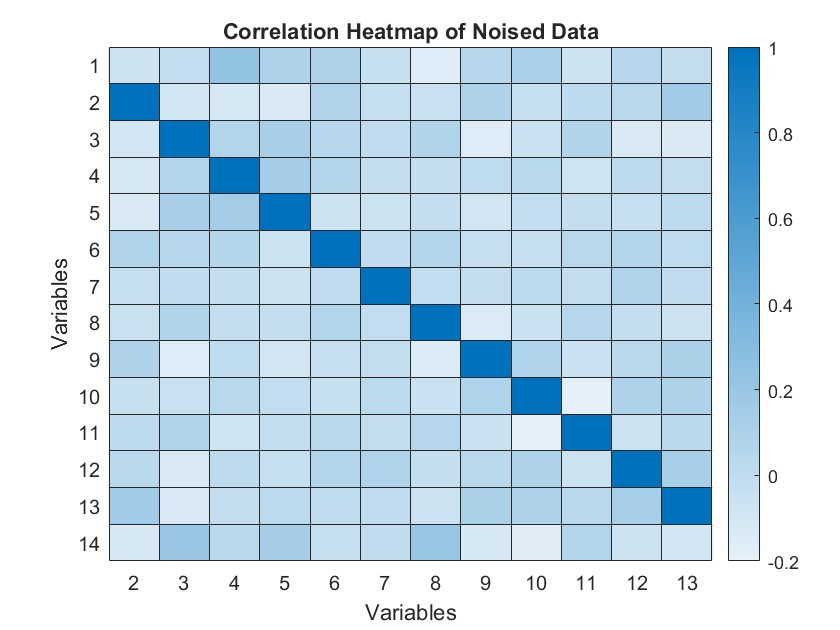

<h5>The difference between the First Correlation Heatmap and the second one with the noise is evident: in the second one the colors of the cells are to the white instead of the blue of the previous one. This means that the data are not so much correlated each other and it is a good example of how data can be anonymized using this tecnique.

In [40]:
heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [41]:
#Load the dataset
#heart_df1 = pd.read_csv("heart.csv")

def replace_last_digit_with_asterisk(age):
   return str(age)[:-1] + "*"

heartdf['age'] = heartdf['age'].apply(replace_last_digit_with_asterisk)

#heart_df = heartdf[heartdf['trtbps'] < 170]
heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,6*,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,3*,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,4*,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,5*,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,5*,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,5*,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,4*,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,6*,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,5*,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [42]:
def generalize_k_anonymity(df, quasi_identifiers, k):
    df['chol_bin'] = pd.cut(df['chol'], bins=5, labels=False)
    df['trtbps_bin'] = pd.cut(df['trtbps'], bins=5, labels=False)
    #df['trtbps_bin'] = df['trtbps']
    anonymized_df = df.groupby(quasi_identifiers).filter(lambda x: len(x) >= k)
    return anonymized_df

k_anonymous_df = generalize_k_anonymity(heartdf.copy(), ['chol_bin', 'trtbps_bin'], k=3)

print("K-Anonymized Dataset:")
print(k_anonymous_df.head())

#L DIVERSITY
def apply_l_diversity(df, quasi_identifiers, sensitive_attribute, l):
    groups = df.groupby(quasi_identifiers)

    # Filter groups that meet the l-diversity requirement (at least l distinct values of the sensitive attribute)
    l_diverse_df = groups.filter(lambda x: x[sensitive_attribute].nunique() >= l)

    return l_diverse_df

# apply l-diversity (l=2) on the k-anonymous dataset using 'output' as the sensitive attribute
l_diverse_df = apply_l_diversity(k_anonymous_df, ['chol_bin', 'trtbps_bin'], 'output', l=2)

print("\nL-Diverse Dataset:")
l_diverse_df

#print("Number of rows after k-anonymity:", len(k_anonymous_df))
#print("Number of rows after l-diversity:", len(l_diverse_df))

#print("\nChecking diversity in each group:")
#grouped = k_anonymous_df.groupby(['chol_bin', 'trtbps_bin'])['output'].nunique()
#grouped


K-Anonymized Dataset:
  age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  caa  \
0  6*    1   3     145   233    1        0       150     0      2.3    0    0   
1  3*    1   2     130   250    0        1       187     0      3.5    0    0   
2  4*    0   1     130   204    0        0       172     0      1.4    2    0   
3  5*    1   1     120   236    0        1       178     0      0.8    2    0   
4  5*    0   0     120   354    0        1       163     1      0.6    2    0   

   thall  output  chol_bin  trtbps_bin  
0      1       1         1           2  
1      2       1         1           1  
2      2       1         0           1  
3      2       1         1           1  
4      2       1         2           1  

L-Diverse Dataset:


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,chol_bin,trtbps_bin
0,6*,1,3,145,233,1,0,150,0,2.3,0,0,1,1,1,2
1,3*,1,2,130,250,0,1,187,0,3.5,0,0,2,1,1,1
2,4*,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0,1
3,5*,1,1,120,236,0,1,178,0,0.8,2,0,2,1,1,1
4,5*,0,0,120,354,0,1,163,1,0.6,2,0,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,5*,0,0,140,241,0,1,123,1,0.2,1,0,3,0,1,2
299,4*,1,3,110,264,0,1,132,0,1.2,1,0,3,0,1,0
300,6*,1,0,144,193,1,1,141,0,3.4,1,2,3,0,0,2
301,5*,1,0,130,131,0,1,115,1,1.2,1,1,3,0,0,1


In [43]:
l_diverse_df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,chol_bin,trtbps_bin
0,6*,1,3,145,233,1,0,150,0,2.3,0,0,1,1,1,2
1,3*,1,2,130,250,0,1,187,0,3.5,0,0,2,1,1,1
2,4*,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0,1
3,5*,1,1,120,236,0,1,178,0,0.8,2,0,2,1,1,1
4,5*,0,0,120,354,0,1,163,1,0.6,2,0,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,5*,0,0,140,241,0,1,123,1,0.2,1,0,3,0,1,2
299,4*,1,3,110,264,0,1,132,0,1.2,1,0,3,0,1,0
300,6*,1,0,144,193,1,1,141,0,3.4,1,2,3,0,0,2
301,5*,1,0,130,131,0,1,115,1,1.2,1,1,3,0,0,1
